# High-Level Setup & Imports

In [1]:
import torch

# General Python Packages
import os, time, numbers, math

# Torch Packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torch import nn
from torch.nn import DataParallel
from torch.nn import Module

# General Analytics Packages
import pandas as pd
import numpy as np

# Visualization / Image Packages
import matplotlib.pyplot as plt
from PIL import Image

# Randomization Functions
from random import random as randuni

### Model Evaluation Helper Classes

In [2]:
class TotalSumMeter:
    def __init__(self):
        self.obs_counter = 0.0
        self.total_pred = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        self.total_act = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        
    def update(self, preds, actuals):
        self.total_act += actuals.sum(0).cpu()
        self.total_pred += preds.sum(0).cpu()
        self.obs_counter += len(actuals)
        
    def get_results(self):
        return {
            'pred': self.total_pred / self.obs_counter,
            'act': self.total_act / self.obs_counter
            }

In [3]:
class MultiClassAUCMeter:
    """ Wrapper on the normal AUCMeter to handle multi-class predictions """
    def __init__(self, num_class):
        self.num_class = num_class
        self.meters = []
        for i in range(self.num_class):
            self.meters.append(AUCMeter())

    def add(self, output, target):
        for i in range(self.num_class):
            self.meters[i].add(output[:,i], target[:,i])
        
    def value(self):
        output = []
        for i in range(self.num_class):
            output.append(self.meters[i].value())
        return output

In [4]:
class AUCMeter:
    """
    SOURCE: https://github.com/pytorch/tnt/blob/master/torchnet/meter/aucmeter.py
    
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """
    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)

In [5]:
class ModelEvaluator:
    def __init__(self, model, dataset, num_classes = 14):
        self.model = model
        self.dataset = dataset
        self.num_classes = num_classes
        self.is_run = False
        
    def score_obs(self, data_row):
        inputs, actuals = data_row

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()
        
        return preds, actuals
    
    def run(self, force_rerun = False):
        if self.is_run and not force_rerun:
            print("Already evaluated this...")
            return None
        
        self.model.train(False)
    
        self.m_total_sums = TotalSumMeter()
        self.m_auc = MultiClassAUCMeter(self.num_classes)

        for data in self.dataset:
            preds, actuals = self.score_obs(data)

            self.m_total_sums.update(preds, actuals)
            self.m_auc.add(preds.data, actuals.data)

### Plotting Functions for Model Evaluations

In [6]:
def plot_auc_bar(in_evaluator):
    auc_out = in_evaluator.m_auc.value()
    plt.bar(range(14), [v for v, _, _ in auc_out])

In [7]:
def plot_auc_curves(in_evaluator):
    index_to_label = {idx: val for val, idx in img_data_train.label_to_index.items()}
    auc_out = in_evaluator.m_auc.value()
    
    plt.figure(figsize=(10,8))

    for idx, (auc, tpr, fpr) in enumerate(auc_out):
        disease = index_to_label[idx]
        plt.plot(fpr, tpr, label="{0} (AUC: {1:0.4f})".format(disease, auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Disease')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def plot_compare_sums(in_evaluator, bar_width = 0.4):
    sums_out = in_evaluator.m_total_sums.get_results()
    
    act = sums_out['act'].data.numpy()
    pred = sums_out['pred'].data.numpy()
    
    indx1 = range(14)
    indx2 = [i+bar_width for i in indx1]

    plt.bar(indx1, act,  width=bar_width, label="Actual")
    plt.bar(indx2, pred, width=bar_width, label="Predicted")
    
    plt.xticks(indx1, img_data_train.labels, rotation=90)
    plt.legend()

### Model Classes

In [9]:
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    """ TODO: Research paper also excludes these labels but need to figure out how to handle
              cases that have these as positive findings (completely exclude?)
    excluded_labels = ['Edema','Hernia','Emphysema','Fibrosis','No Finding'
                      'Pleural_Thickening','Consolidation']
    """
    excluded_labels = ['No Finding']
    
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
    
    # Drop some label that we do not want to include
    unique_labels = sorted([l for l in unique_labels if l not in excluded_labels])

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    f = open(path, 'rb')
    return Image.open(f)
    #with open(path, 'rb') as f:
    #    return Image.open(f)
        #with Image.open(f) as img:
        #    return img.load()
        
def imshow(inp, title=None):
    """ Convert tensor array to an image (only use post-dataset transform) """
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
class XrayImageSet(Dataset):
    """
    Args:
        image_root (string): root directory of the images in form image/subfolder/*.png
        csv_file (string): path to the CSV data file
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        labels (list): list of the possible label names.
        label_to_index (dict): look from label name to a label index
        imgs (list): List of (filename, image path) tuples
    """
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """ Calculate length of the dataset (number of images) """
        return len(self.imgs)
    
    def get_labels(self, fname):
        """ Return the label string for the file """
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        """ Convert the labels string (with each label separated by |) into 1-hot encoding """
        if labels == None:
            return None
        
        split_label_indices = [self.label_to_index.get(label)
                               for label in labels.split('|')
                               if label != 'No Finding']
        
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        """ Get the 1-hot encoded label array for the provided file """
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return torch.FloatTensor(one_hot_labels)

In [11]:
def ResNetBase(base_size = 18, only_update_fc = True, pretrain = True):
    """ ResNet 18 with only final FC layer updatable """
    m = None
    if base_size == 18:
        m = models.resnet18(pretrained=pretrain)
    elif base_size == 34:
        m = models.resnet34(pretrained=pretrain)
    elif base_size == 50:
        m = models.resnet50(pretrained=pretrain)
    elif base_size == 101:
        m = models.resnet101(pretrained=pretrain)
    elif base_size == 152:
        m = models.resnet152(pretrained=pretrain)
    
    if only_update_fc:
        for param in m.parameters():
            param.requires_grad = False

    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [52]:
def load_trained_model(model_name):
    path = '/user/xrayproj/output/' + model_name
    params = [18, True, True]
    
    if model_name == 'resnet18_onlyfc':
        path += '/model_10.tar'
        params = [18, True, True]
    elif model_name == 'resnet18_all_layers':
        path += '/model_10.tar'
        params = [18, False, True]
    elif model_name == 'resnet18_all_layers_imgflip':
        path += '/model_10.tar'
        params = [18, False, True]
    elif model_name == 'resnet18_notpretrained':
        path += '/model_20.tar'
        params = [18, False, False]
    elif model_name == 'resnet18_onlyfc':
        path += '/model_10.tar'
        params = [18, True, True]
    elif model_name == 'resnet34_all_layers_imgflip':
        path += '/model_10.tar'
        params = [34, True, True]
    elif model_name == 'resnet34_all_layers_imgflip_wbce':
        path += '/model_10.tar'
        params = [34, True, True]
    elif model_name == 'resnet50_all_layers_imgflip':
        path += '/model_10.tar'
        params = [50, False, True]
    
    tmp_state = torch.load(path)['state']
    model = ResNetBase(base_size = params[0], only_update_fc = params[1], pretrain = params[2])
    
    model_ft = DataParallel(model).cuda()
    model_ft.load_state_dict(tmp_state)
    
    return model_ft

# Setup

In [13]:
nn_input_size = 224 #1024
batch_size = 64
pin_mem_setting = True
num_gpus = torch.cuda.device_count()
num_workers = 10

print("Number of GPU: {}".format(num_gpus))

Number of GPU: 1


In [14]:
img_transforms_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [15]:
img_transforms_nontrain = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [16]:
img_data_train = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_train,
                              target_transform = None)

img_data_train.imgs = [img for i, img in enumerate(img_data_train.imgs) if i % 10 >= 3]

In [17]:
img_data_val   = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_nontrain,
                              target_transform = None)

img_data_val.imgs = [img for i, img in enumerate(img_data_val.imgs) if i % 10 in (1,2)]

In [18]:
img_data_test  = XrayImageSet(image_root = '/user/images_processed/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms_nontrain,
                              target_transform = None)

img_data_test.imgs = [img for i, img in enumerate(img_data_test.imgs) if i % 10 == 0]

In [19]:
train_set = set(img_data_train.imgs)
val_set = set(img_data_val.imgs)
test_set = set(img_data_test.imgs)
assert len(train_set.intersection(val_set)) == 0
assert len(train_set.intersection(test_set)) == 0
assert len(val_set.intersection(test_set)) == 0

In [20]:
print("Training Set Size: {}".format(len(img_data_train)))
print("Validation Set Size: {}".format(len(img_data_val)))
print("Test Set Size: {}".format(len(img_data_test)))

Training Set Size: 78484
Validation Set Size: 22424
Test Set Size: 11212


In [21]:
img_loader_train = DataLoader(img_data_train,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

img_loader_val   = DataLoader(img_data_val,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

img_loader_test  = DataLoader(img_data_test,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = num_workers,
                              pin_memory = pin_mem_setting)

In [22]:
dataloaders = {
    'train': img_loader_train,
    'val': img_loader_val,
    'test': img_loader_test
}

# Loading & Analysis of Model Results

```
mkdir /user/s3_models
mkdir /user/s3_models/resnet18_all_layers/
mkdir /user/s3_models/resnet18_all_layers_imgflip/
mkdir /user/s3_models/resnet18_notpretrained/
mkdir /user/s3_models/resnet18_onlyfc/
mkdir /user/s3_models/resnet34_all_layers_imgflip/
mkdir /user/s3_models/resnet50_all_layers_imgflip/

cd /user/s3_models/resnet18_all_layers/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_all_layers/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_all_layers/model_10.tar .

cd /user/s3_models/resnet18_all_layers_imgflip/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_all_layers_imgflip/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_all_layers_imgflip/model_10.tar .

cd /user/s3_models/resnet18_notpretrained/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_notpretrained/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_notpretrained/model_20.tar .

cd /user/s3_models/resnet18_onlyfc/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_onlyfc/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet18_onlyfc/model_10.tar .

cd /user/s3_models/resnet34_all_layers_imgflip/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet34_all_layers_imgflip/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet34_all_layers_imgflip/model_10.tar .

cd /user/s3_models/resnet50_all_layers_imgflip/
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet50_all_layers_imgflip/print.txt .
aws s3 cp s3://bdh-xrayproj-modelparameters/resnet50_all_layers_imgflip/model_10.tar .
```

In [33]:
model_evals = {}

In [53]:
model_type_list = [
    'resnet18_all_layers',
    'resnet18_all_layers_imgflip',
    'resnet18_onlyfc',
    'resnet34_all_layers_imgflip',
    'resnet34_all_layers_imgflip_wbce',
    'resnet50_all_layers_imgflip']
    #'resnet18_notpretrained',

In [54]:
for model_type in model_type_list:
    print("Running model type: " + str(model_type))
    model_ft = load_trained_model(model_type)

    model_evals[model_type] = {}

    model_evals[model_type]['val'] = ModelEvaluator(model_ft, dataloaders['val'])
    model_evals[model_type]['train'] = ModelEvaluator(model_ft, dataloaders['train'])
    model_evals[model_type]['test'] = ModelEvaluator(model_ft, dataloaders['test'])
    
    model_evals[model_type]['train'].run()
    print(" -- Completed training evaluation!")
    model_evals[model_type]['val'].run()
    print(" -- Completed validation evaluation!")
    model_evals[model_type]['test'].run()
    print(" -- Completed testing evaluation!")

Running model type: resnet34_all_layers_imgflip_wbce
 -- Completed training evaluation!
 -- Completed validation evaluation!
 -- Completed testing evaluation!


In [55]:
#torch.save(model_evals, '/user/xrayproj/model_evals_final.out')

In [56]:
for model_type in model_type_list:
    for data_type in ['train','val','test']:
        print("model_type: {0}  data_type: {1}".format(model_type, data_type))
        
        auc_out = model_evals[model_type][data_type].m_auc.value()
        out = []
        for auc, _, _ in auc_out:
            out.append(auc)
        
        print(out)

model_type: resnet18_all_layers  data_type: train
[0.82788507511096188, 0.86048137948628911, 0.81877622080019574, 0.91022902333234379, 0.89327272420116977, 0.91085653801859856, 0.83312780077306081, 0.88061966914573309, 0.75334678873423044, 0.83384601233626132, 0.77594185388398329, 0.82423336249705115, 0.78145269160373765, 0.89576910266741627]
model_type: resnet18_all_layers  data_type: val
[0.77861035175235016, 0.88783140074596134, 0.78537473020341897, 0.88699204954503275, 0.8687284650784648, 0.89358516081592698, 0.78153545371563227, 0.80643488073761271, 0.69762703227432454, 0.78619116479595519, 0.71566324132913595, 0.778008414326259, 0.72853776002702375, 0.86772177886996371]
model_type: resnet18_all_layers  data_type: test
[0.7941335783964355, 0.89426425686205913, 0.79425173150282879, 0.89485883973577141, 0.87017171854017261, 0.88059464100410134, 0.79842553000104943, 0.83913818316899191, 0.70289814985555354, 0.81314491019194968, 0.71370670821039262, 0.78130579828797075, 0.748854264010

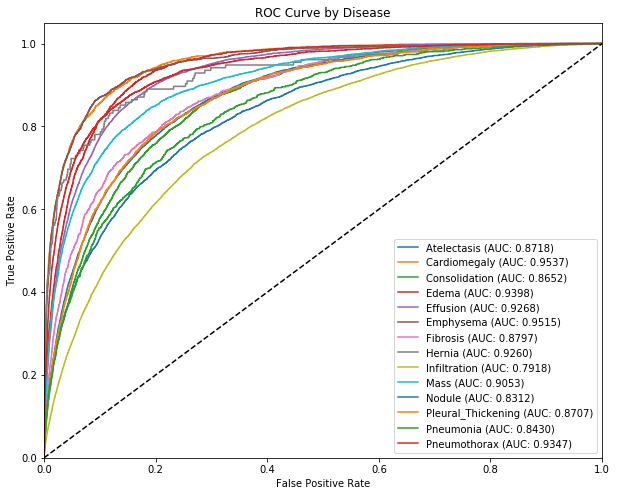

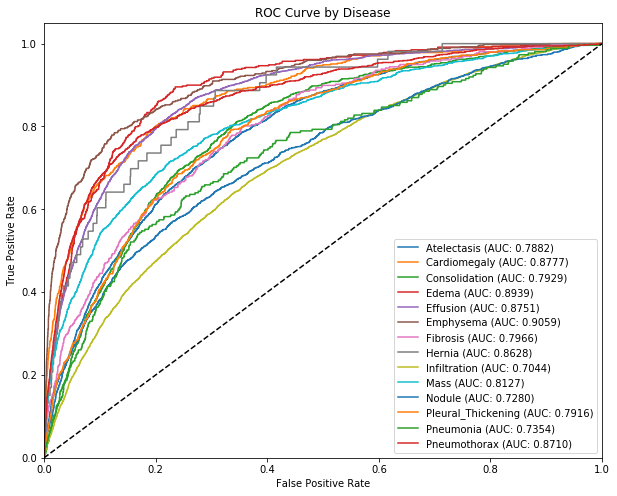

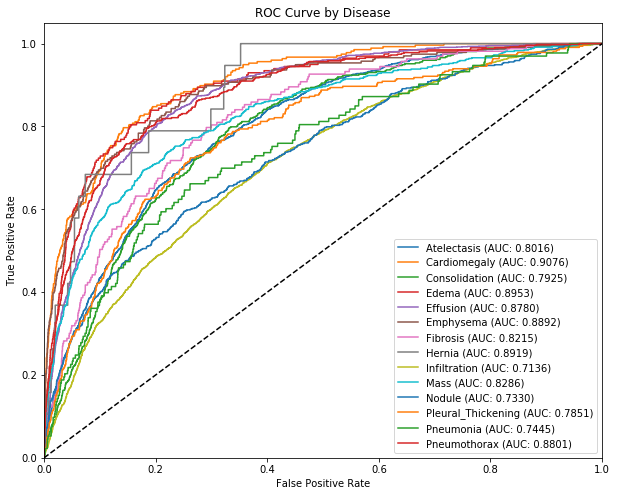

In [57]:
plot_auc_curves(model_evals['resnet34_all_layers_imgflip_wbce']['train'])
plot_auc_curves(model_evals['resnet34_all_layers_imgflip_wbce']['val'])
plot_auc_curves(model_evals['resnet34_all_layers_imgflip_wbce']['test'])

### Older Junk (TODO: Cleanup)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Training Sums")
#plot_compare_sums(epoch_evals[epoch]['train'])

plt.subplot(1,2,2)
plt.title("Validation Sums")
plot_compare_sums(epoch_evals[epoch]['val'])

In [ ]:
def single_model_run(model, dataset):
    dataset
    for data in self.dataset:
        inputs, actuals = data

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()

        self.m_total_sums.update(preds, actuals)
        self.m_auc.add(preds, actuals)

In [ ]:
comparison = Variable(torch.FloatTensor(9, 14))
for i in range(9):
    comparison[0] = conf_a[1] / obs_counter
print(comparison.int())

In [ ]:
out_model_30.train(mode=False)

obs_counter = 0
total_pred = Variable(torch.FloatTensor(torch.zeros(14)))
total_act = Variable(torch.FloatTensor(torch.zeros(14)))

conf_a = {}
conf_b = {}
conf_c = {}
conf_d = {}
for i in range(1,10):
    conf_a[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_b[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_c[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_d[i] = Variable(torch.FloatTensor(torch.zeros(14)))

for data in dataloaders['val']:
    print("STARTING ITERATION...")
    inputs, labels = data
    print("PROCESSING FIRST {} OBSERVATIONS".format(len(inputs)))

    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    outputs = out_model_30(inputs).sigmoid()
    
    total_act += labels.sum(0).cpu()
    total_pred += outputs.sum(0).cpu()

    # Store statistics (convert from autograd.Variable to float/int)
    for i in range(1,10):
        t = i/10
        conf_a[i] += ((outputs.sigmoid()>t) == (labels>0.5)).sum(0).cpu().float()
        conf_b[i] += ((outputs.sigmoid()<t) == (labels>0.5)).sum(0).cpu().float()
        conf_c[i] += ((outputs.sigmoid()>t) == (labels<0.5)).sum(0).cpu().float()
        conf_d[i] += ((outputs.sigmoid()<t) == (labels<0.5)).sum(0).cpu().float()

    obs_counter += len(inputs)